# Ferrofluid-Monolayer - Part II

## Table of Contents
1. [Applying an external magnetic field](#Applying-an-external-magnetic-field)
2. [Magnetization curve](#Magnetization-curve)

## Applying an external magnetic field

In this part we want to investigate the influence of an external magnetic field exposed to the ferrofluid system.

We import all neccessary packages

In [2]:
import espressomd

from espressomd.magnetostatics import DipolarP3M
from espressomd.magnetostatic_extensions import DLC

import numpy as np

and set up the simulation parameters where we introduce a new dimensionless parameter $\alpha = \frac{\mu_0 \mu H}{k_BT}$ which is called Langevin parameter

In [11]:
# Lennard-Jones parameters
lj_sigma = 1
lj_epsilon = 1
lj_cut = 2**(1./6.) * lj_sigma

# Particles
N = 1000

# Area fraction of the mono-layer 
phi = 0.1

# Dipolar interaction parameter lambda = mu_0 m^2 /(4 pi sigma^3 kT)
dip_lambda = 4

# Temperature
kT =1.0

# Friction coefficient
gamma = 1.0

# Time step
dt = 0.01

# Verlet list skin
skin = 0.4

# Langevin parameter alpha = mu_0 m H / kT
alpha = 40
mu_0 = 4*np.pi

## dipole moment
#dipm = np.sqrt(dip_lambda*4*np.pi*lj_sigma**3*kT / mu_0)

Now we set up the system (for more details see Part I)

In [6]:
# System setup
box_size = (N * np.pi * (lj_sigma/2.)**2 /phi)**0.5

print("Box size",box_size)
# Note that the dipolar P3M and dipolar layer correction need a cubic
# simulation box for technical reasons.
system=espressomd.System(box_l=(box_size,box_size,box_size)) 
system.time_step=dt
system.cell_system.skin=skin
system.thermostat.set_langevin(kT=kT,gamma=gamma)
system.set_random_state_PRNG()

# Lennard-Jones interaction
system.non_bonded_inter[0,0].lennard_jones.set_params(epsilon=lj_epsilon,sigma=lj_sigma,cutoff=lj_cut, shift="auto")

# Random dipole moments
dip_phi=np.random.random((N,1)) *2. * np.pi
dip_cos_theta = 2*np.random.random((N,1)) -1
dip_sin_theta = np.sin(np.arccos(dip_cos_theta))
dip = np.hstack((
   dip_sin_theta *np.sin(dip_phi),
   dip_sin_theta *np.cos(dip_phi),
   dip_cos_theta))

# Random positions in the monolayer
pos = box_size* np.hstack((np.random.random((N,2)), np.zeros((N,1))))

# Add particles
system.part.add(pos=pos,rotation=N*[(1,1,1)],dip=dip,fix=N*[(0,0,1)])

# Remove overlap between particles by means of the steepest descent method
system.integrator.set_steepest_descent(
    f_max=0,gamma=0.1,max_displacement=0.05)

while system.analysis.energy()["total"] > 5*kT*N:
    system.integrator.run(20)

# Switch to velocity Verlet integrator
system.integrator.set_vv()

# Setup dipolar P3M and dipolar layer correction
system.actors.add(DipolarP3M(accuracy=5E-4,prefactor=dip_lambda*lj_sigma**3*kT))
system.actors.add(DLC(maxPWerror=1E-4, gap_size=box_size-lj_sigma))

('Box size', 88.6226925452758)
Dipolar P3M tune parameters: Accuracy goal = 5.00000e-04 prefactor = 4.00000e+00
System: box_l = 8.86227e+01 # charged part = 1000 Sum[q_i^2] = 1.00000e+03
Dmesh cao Dr_cut_iL   Dalpha_L     Derr         Drs_err    Dks_err    time [ms]
8    3   1.01613e-01 1.65772e+01 4.94321e-04 3.536e-04 3.455e-04 3       
8    2   1.06452e-01 1.51807e+01 4.95764e-04 3.536e-04 3.475e-04 2       
8    4   9.87102e-02 1.74732e+01 4.98746e-04 3.536e-04 3.518e-04 3       
8    1   1.17097e-01 1.24634e+01 4.98587e-04 3.536e-04 3.516e-04 3       
16   2   1.02294e-01 1.63738e+01 4.99744e-04 3.536e-04 3.532e-04 3       
16   1   1.06452e-01 1.51807e+01 6.79130e-04 3.536e-04 5.798e-04 accuracy not achieved
16   3   9.81356e-02 1.76563e+01 4.86580e-04 3.536e-04 3.343e-04 4       
16   4   9.48090e-02 1.87559e+01 4.96228e-04 3.536e-04 3.482e-04 4       
16   5   9.31457e-02 1.93331e+01 4.92612e-04 3.536e-04 3.430e-04 6       
32   2   8.55113e-02 2.22553e+01 4.97357e-04 3.536e-04

We now apply the external magnetic field which is

\begin{equation}
    H = \frac{\alpha~k_BT}{\mu_0 m}
\end{equation}

As only the current orientation of the dipole moments is saved in the particle list but not their strength we have to commit $H\cdot \mu$ as the external magnetic field to ESPResSo.
We applying the field in x-direction using the class <tt>constraints</tt> of ESPResSo

In [12]:
# magnetic field times dipole moment
H_dipm = (alpha*kT) / mu_0
H_field = [H_dipm,0,0]
print("Set magnetic field constraint...")
H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
system.constraints.add(H_constraint)

Set magnetic field constraint...


and equilibrate the system for a while

In [13]:
# Equilibrate
print("Equilibration")
for i in range(20):
  system.integrator.run(5000)
  print("Dipolar energy",system.analysis.energy()["dipolar"])

Equilibration
('Dipolar energy', -9854.997666725765)


Now we can visualize the current state and see that the particles mostly create chains oriented in the direction of the external magnetic field

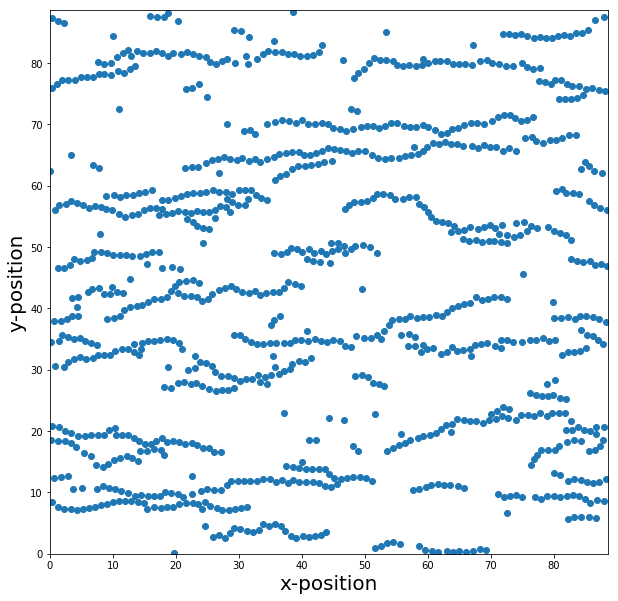

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.xlim(0, box_size)
plt.ylim(0, box_size)
plt.xlabel('x-position', fontsize=20)
plt.ylabel('y-position', fontsize=20)
plt.plot(system.part[:].pos_folded[:,0], system.part[:].pos_folded[:,1], 'o')
plt.show()

## Video of the development of the system

You may want to get an insight of how the system develops in time. Thus we now create a function which will save the video and embed it in an html string to create a video of the systems development 

In [22]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
        plt.close(anim._fig)
    return VIDEO_TAG.format(anim._encoded_video)

animation.Animation._repr_html_ = anim_to_html

def init():
    # Set x and y range
    ax.set_ylim(0, box_size)
    ax.set_xlim(0, box_size)
    xdata, ydata = [], []
    part.set_data(xdata, ydata)
    return part,

def run(i):
    system.integrator.run(100)

    # Save current system state as a plot
    xdata, ydata = system.part[:].pos_folded[:,0], system.part[:].pos_folded[:,1]
    ax.figure.canvas.draw()
    part.set_data(xdata, ydata)
    return part,

We now can start the sampling over the <tt>animation</tt> class of <tt>matplotlib</tt>

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
part, = ax.plot([],[], 'o')

animation.FuncAnimation(fig, run, frames=100, blit=True, interval=0, repeat=False, init_func=init)

In the visualization video we can see that the single chains break and connect to each other during time. Also some monomers are present which break from and connect to chains.

## Magnetization curve

An important observable of a ferrofluid system is the magnetization $M$ of the system in direction of an external magnetic field $H$

\begin{equation}
    M = \frac{\sum_i \mu_i^H}{V}
\end{equation}

where the index $H$ means the component of $\mu_i$ in direction of the external magnetic field $H$ and the sum runs over all particles.

The magnetization plotted over the external field $H$ is called magnetization curve. For particles with non-interacting dipole moments there is an analytical solution

\begin{equation}
    M = M_{sat}\cdot L(\alpha)
\end{equation}

with $L(\alpha)$ the Langevin function

\begin{equation}
    L(\alpha) = \coth(\alpha)-\frac{1}{\alpha}
\end{equation}

and $\alpha$ the Langevin parameter

\begin{equation}
    \alpha=\frac{\mu_0\mu}{k_BT}H
\end{equation}

$M_{sat}$ is the so called saturation magnetization which is the magnetization of a system where all dipole moments are aligned to each other. Thus it is the maxima of the magnetization. In our case all dipole moments are equal, thus

\begin{equation}
    M_{sat} = \frac{N\cdot\mu}{V}
\end{equation}


For better compairability we now introduce a dimensionless magnetitzation

\begin{equation}
    M^* = \frac{M}{M_{sat}} = \frac{\sum_i \mu_i^H}{N\cdot \mu}
\end{equation}

Thus the analytical solution for non-interacting dipole moments $M^*$ is simply the Langevin function.

For interacting dipole moments there is no analytical solution for the magnetization curve available, thus we now want to use ESPResSo to get an estimation of how the magnetization curve is affected by the dipole-dipole interaction.

To increase the perfomance we use the build-in function <tt>MagneticDipoleMoment</tt> to calculate the dipole  moment of the whole system. In our case this is only the orientation as we never commited the strength of the dipole moments to our particles. 

In [24]:
from espressomd.observables import MagneticDipoleMoment
dipm_tot = MagneticDipoleMoment(ids=system.part[:].id)

We use the dimensionless Langevin parameter $\alpha$ as the parameter for the external magnetic field. As we want the magnetization curve we create a list of them

In [ ]:
alphas = np.arange(0,10).tolist()

Now we can sample the magnetization for the different $\alpha$

In [ ]:
# list of magnetisation in field direction
magnetization = []

# number of loops for sampling
loops = 100

for alpha in alphas:
    H_dipm = (alpha*kT) / mu_0
    H_field = [H_dipm,0,0]
    print("Set magnetic field constraint...")
    H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
    system.constraints.add(H_constraint)
    
    # Equilibration
    print("Equilibration")
    for i in range(5):
        system.integrator.run(5000)
        print("Dipolar energy",system.analysis.energy()["dipolar"])
    
    # Sampling
    magn_temp = 0
    for i in range(loops):
        system.integrator.run(100)
        magn_temp += dipm_tot.calculate()[0]
    
    # save average magnetisation
    magnetization.append(magn_temp / loops)
    
    system.constraints.remove(H_constraint)

Now we can compare the resulting magnetization curve with the Langevin curve by plotting both in one figure

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Langevin function
def L(y):
    return np.cosh(y)/np.sinh(y)-1/y

y = np.arange(0.01,10, 0.1, dtype=float).tolist()


L_func = []
for i in y:
    L_func.append(L(i))

# devide all entries in the magnetization list by N to get the dimensionless magnetization
magnetization_star = []
for i in range(len(magnetization)):
    magnetization_star.append(magnetization[i] / N)

plt.figure(figsize=(10,10))
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$M^*$', fontsize=20)
plt.plot(y, L_func, label='Langevin function')
plt.plot(alphas, magnetization_star, 'o', label='simulation results')
plt.legend(fontsize=20)
plt.show()

We can see that the initial susceptibility is higher than the one of the Langevin function while the overall shape is similar. 

??Feel free to experiment with different dipolar interaction parameters $\lambda$ up to around 4 and different area fractions $\phi$ up to around 0.4. For higher values the here used simple sampling is not applicable as the particles form clusters of very high relaxation times exceeding normal simulation times by far. More advanced methods are necessary to increase the sampling performance.??